# Data preprocessing

Notebook for developing data preprocessing pipeline

In [1]:
%matplotlib inline

import gym
import numpy as np
import matplotlib.pyplot as plt
import time

from skimage.transform import resize

In [2]:
stacked_frames = 4
memory_size = 100

In [3]:
def rgb2grayscale(array_rgb):
    """
    Expects 3d numpy array with (R, G, B) as last dimension (eg 210x160x3)
    """
    consts = np.array([0.2989, 0.5870, 0.1140])
    array_grayscale = np.sum(array_rgb * consts[None, None, :], axis=-1)
    return array_grayscale

For experience replay

In [4]:
# These four together form the memory consisting of experiences e = (s,a,r,s')
states = np.zeros(shape=(memory_size, 84, 84, stacked_frames))
actions = np.zeros(shape=(memory_size))
rewards = np.zeros(shape=(memory_size))
new_states = np.zeros(shape=(memory_size, 84, 84, stacked_frames))

last_frames = np.zeros(shape=(stacked_frames, 84, 84))
last_frame = np.zeros(shape=(210, 160, 3))

previous_state = np.zeros(shape=(stacked_frames, 84, 84))
previous_action = None
previous_reward = None

Game loop

In [6]:
env = gym.make('Breakout-v0')
observation = env.reset()
for t in range(1000):
    # Interact with environment
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    
    # Max over last two frames, conversion RGB -> grayscale, rescale
    frame = np.where(last_frame > observation, last_frame, observation)
    frame = rgb2grayscale(frame)
    frame = resize(frame, (84, 84))
    
    # Stacking last four frames and assigning last frame (observation)
    last_frames = np.concatenate((last_frames[1:], frame[None, :]))
    last_frame = observation

    # Saving data for memory replay
    if t >= (stacked_frames):
        states[t % memory_size] = previous_state
        actions[t % memory_size] = previous_action
        rewards[t % memory_size] = previous_reward
        new_states[t % memory_size] = np.moveaxis(last_frames, 0, 2)

    # Keep to save in next iteration together with new state
    previous_state = np.moveaxis(last_frames, 0, 2)
    previous_action = action
    previous_reward = reward
    
    if done:
        print("Episode finished after {} timesteps".format(t + 1))
        break
env.close()

Episode finished after 161 timesteps


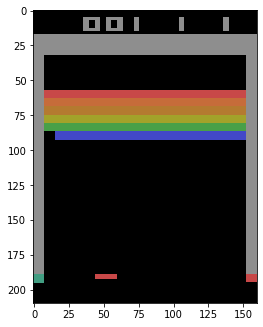

In [25]:
width, height = 4, 8
fig = plt.figure(figsize=(width, height))
fig.add_subplot()
plt.imshow(last_frame, interpolation='nearest')

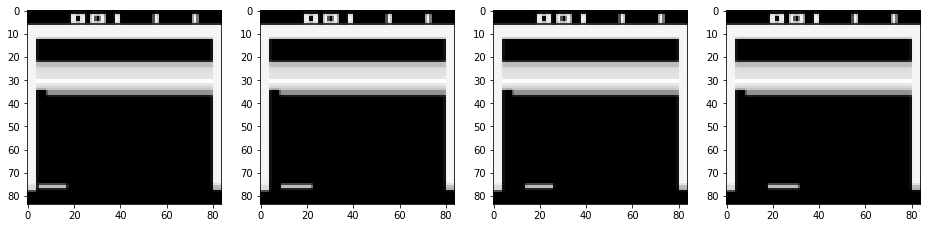

In [26]:
width, height = 16, 8
fig = plt.figure(figsize=(width, height))
for i in range(4):
    fig.add_subplot(1, 4, i + 1)
    plt.imshow(last_frames[i]/255, interpolation='nearest', cmap='gray')

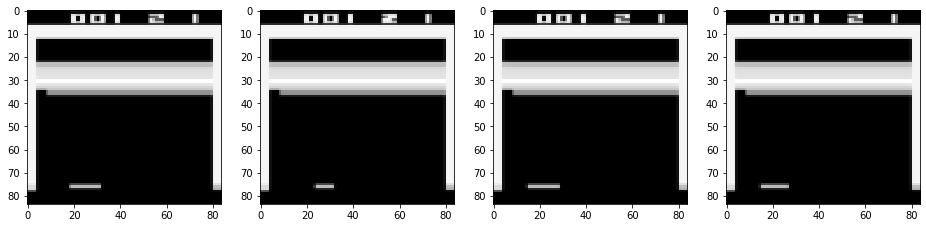

In [27]:
width, height = 16, 8
fig = plt.figure(figsize=(width, height))
positions = [0, 1, -2, -1]
for i in range(4):
    fig.add_subplot(1, 4, i + 1)
    plt.imshow(states[positions[i]][:, :, 0]/255, interpolation='nearest', cmap='gray')

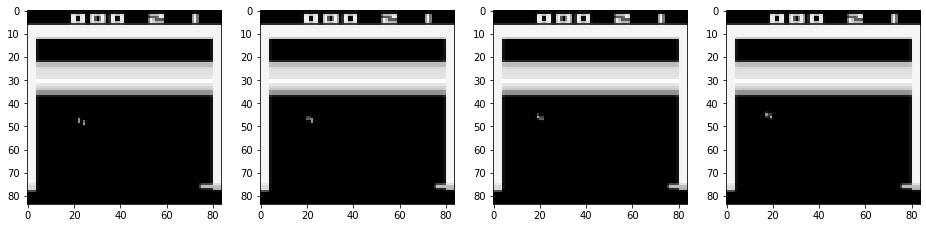

In [28]:
width, height = 16, 8
fig = plt.figure(figsize=(width, height))
for i in range(4):
    fig.add_subplot(1, 4, i + 1)
    plt.imshow(states[50][:, :, i]/255, interpolation='nearest', cmap='gray')

In [29]:
actions

array([3., 1., 1., 0., 1., 3., 0., 0., 3., 1., 2., 1., 3., 0., 1., 2., 3.,
       0., 2., 1., 1., 1., 3., 0., 0., 2., 2., 1., 2., 0., 1., 0., 1., 1.,
       1., 2., 0., 1., 3., 3., 2., 0., 2., 1., 1., 3., 0., 2., 3., 0., 0.,
       3., 1., 2., 2., 1., 3., 3., 2., 1., 2., 3., 1., 2., 2., 2., 0., 2.,
       1., 2., 3., 1., 0., 3., 3., 0., 3., 3., 3., 0., 0., 0., 2., 2., 1.,
       1., 0., 2., 1., 3., 3., 3., 1., 0., 3., 1., 2., 0., 3., 3.])

In [30]:
rewards

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [33]:
np.all(states[1] == new_states[0])

True